In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo.gates import M, X, RY, CZ, I
from qibo.models import Circuit
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

api = API(ConnectionConfiguration(username="qat", api_key="meow"))
api.select_device_id(9)

## To-do's
 - See which bell states correspond to which inequalities
 - Check double RY rotation on control qubit in get_decoder_circuits
 - Continue changing the format

psi minus 

In [2]:
CONTROL_QUBIT = 2
TARGET_QUBIT = 4
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "psi_minus"
CALIBRATE = False

M_BUFFER_TIME = 0
HW_AVG = 1
REPETITION_DURATION = 200_000
NUM_SHOTS = 2000
PLATFORM_PATH = "../../QuantumPainHackathon/runcards/soprano_master_galadriel_main.yml"

In [3]:
def get_chsh_circuit(bell_state, control_qubit, target_qubit):
    assert bell_state in ("phi_plus", "phi_minus", "psi_plus", "psi_minus"), "bell_state should be phi_plus, phi_minus, psi_plus, psi_minus"
    nqubits = max(control_qubit, target_qubit) + 1
    circuit = Circuit(nqubits)

    if bell_state == "phi_plus" or bell_state == "psi_minus":
        G1 = RY(control_qubit, theta=-np.pi/2)
    else:
        G1 = RY(control_qubit, theta=np.pi/2)
    if bell_state == "phi_plus" or bell_state == "phi_minus":
        G2_prime = RY(target_qubit, theta=-np.pi/2)
    else:
        G2_prime = RY(target_qubit, theta=np.pi/2)

    circuit.add(G1) # gate 0
    circuit.add(RY(target_qubit, theta=np.pi/2)) # gate 1
    circuit.add(CZ(control_qubit, target_qubit)) # gate 2
    circuit.add(G2_prime) # gate 3
    return circuit


def get_decoder_circuits(control_qubit, target_qubit):
    # ZZ measurments
    nqubits = max(control_qubit, target_qubit) + 1
    circuit = Circuit(nqubits)

    # add parameterized RY for measurment
    circuit.add(RY(control_qubit, theta=0))
    # add rotations to mimick I or H for change of measurment basis
    circuit.add(RY(control_qubit, theta=0)) ## FIXME: there are two repeated RYs here
    circuit.add(RY(target_qubit, theta=0))
    circuit.add(M(control_qubit, target_qubit))

    return circuit

In [4]:
""" code copied from Ana's state tomography code """
from itertools import product
from scipy.optimize import minimize

def get_measurement_calibration_bitstrings(processed_data, wlsq_stds=None, initial_guess=None):
    """
    Returns a 4x4 matrix that takes in the measured bitstring probabilities in the order 00, 01, 10, 11 (as (1, 4) vectors)
    and turns them into the corrected probabilities of measuring 00, 01, 10, 11.
    Args:
        processed data (array): array of shape (ncircuits=4, nbitstrings=4) containing the measured probabilities of
                                    finding the 4 basis states for each basis preparation circuit.
        wlsq_stds (array|None): only not None if we want to do statistics over several subsets of data within the number
                                of bins. We are not taking that many measurements anyway at the moment, so currently we
                                don't gain much from it.
        initial_guess (array|None): only considered if wlsq_stds is not None. Initial guess required by the optimizer, if None
                                    it defaults to the independent term.
    """

    coeff_matrix = np.zeros((16, 16))
    ideal_measurements = np.eye(4).flatten()
    for alpha, (experiment_index, bitstring_index) in enumerate(product(range(4), range(4))):
        data_currentcirc = processed_data[experiment_index]
        coeff_matrix[alpha, bitstring_index*4 : 4*(bitstring_index+1)] += data_currentcirc

    ## Solve linear system and solve it
    independent_term = ideal_measurements
    if wlsq_stds is None:
        calibration_matrix = np.linalg.solve(coeff_matrix, independent_term)
    else:
        if initial_guess is None:
            initial_guess = independent_term

        def residuals_weighted_least_squares(x):
            """ We define the chisq function here in order to optimise the least squares with weights."""
            return np.sum( ((independent_term - coeff_matrix @ x) / wlsq_stds )**2 )

        res = minimize(fun=residuals_weighted_least_squares, x0=initial_guess)
        calibration_matrix = res.x

    return calibration_matrix.reshape(4, 4)

In [5]:
chsh_circuit = get_chsh_circuit(BELL_STATE, CONTROL_QUBIT, TARGET_QUBIT)
decoder_circuit = get_decoder_circuits(CONTROL_QUBIT, TARGET_QUBIT)
circuit = chsh_circuit + decoder_circuit

In [6]:
chsh_circuit.add(M(CONTROL_QUBIT, TARGET_QUBIT))
print([(gate.name, gate.qubits, gate.parameters) for gate in chsh_circuit.queue])
print(chsh_circuit())

[Qibo 0.1.12.dev0|INFO|2023-10-18 17:38:14]: Using numpy backend on /CPU:0


[('ry', (2,), (-1.5707963267948966,)), ('ry', (4,), (1.5707963267948966,)), ('cz', (2, 4), ()), ('ry', (4,), (1.5707963267948966,)), ('measure', (2, 4), ())]
(0.70711+0j)|00001> + (-0.70711+0j)|00100>


In [8]:
def SPAM_circuits(control_qubit, target_qubit):
    """ Circuits to get the SPAM matrix in order to perform measurment correction. """
    calibration_circuits = []
    for gate_a in [I, X]:
        for gate_b in [I, X]:
            calibration_circuit = Circuit(5)
            calibration_circuit.add(gate_a(control_qubit))
            calibration_circuit.add(gate_b(target_qubit))
            calibration_circuit.add(M(control_qubit, target_qubit))

            calibration_circuits.append(calibration_circuit)
    return calibration_circuits

# VAMOS POR AQUÍ EN LA CONVERSIÓN AL FORMATO DE QIBOCONNECTION

In [9]:
# Run experiment
chsh_result_theta = []
calibration_result_theta = []

for theta in tqdm(iterable=THETA_VALUES, total=len(THETA_VALUES), desc="Angle"):
    chsh_result = []
    for basis_angle_control in [0, -np.pi / 2]:
        for basis_angle_target in [0, -np.pi / 2]:
            circuit.set_parameters({circuit.queue[-5]: (theta)})
            circuit.set_parameters({circuit.queue[-4]: (basis_angle_control)})
            circuit.set_parameters({circuit.queue[-3]: (basis_angle_target)})

            t_circuit = ql.translate_circuit(circuit)
            result = platform.execute(program=t_circuit,
                                      num_avg=HW_AVG,
                                      repetition_duration=REPETITION_DURATION,
                                      num_bins=NUM_SHOTS)
            chsh_result.append(result.counts())

    # TODO is it overkill to calibrate for each value of theta?
    if CALIBRATE:
        calibration_result = []
        for i, cali_circuit in enumerate(calibration_circuits):
            cali_circuit_transpiled = ql.translate_circuit(cali_circuit)
            cali_result = platform.execute(program=cali_circuit_transpiled,
                                            num_avg=HW_AVG,
                                            repetition_duration=REPETITION_DURATION,
                                            num_bins=NUM_SHOTS)
            calibration_result.append(cali_result.counts())

    chsh_result_theta.append(chsh_result)
    if CALIBRATE:
        calibration_result_theta.append(calibration_result)

#chsh_results = np.hstack(chsh_results)
#calibration_results = np.hstack(calibration_results)

Angle:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
# post-process data for each value of theta
if CALIBRATE:
    measurement_calibration_matrices_theta = []
    for calibration_result in calibration_result_theta:
        # obtain matrix of probabilities - four bitstring for each of the four circuits
        probability_matrix = np.zeros([4, 4])
        for i in range(4):
            probability_matrix[i, 0] = calibration_result[i]["00"]
            probability_matrix[i, 1] = calibration_result[i]["01"]
            probability_matrix[i, 2] = calibration_result[i]["10"]
            probability_matrix[i, 3] = calibration_result[i]["11"]
        # normalize counts to probabilites
        probability_matrix = probability_matrix / probability_matrix.sum(axis=1)

        calibration_matrix = get_measurement_calibration_bitstrings(probability_matrix)
        measurement_calibration_matrices_theta.append(calibration_matrix)

In [11]:
chsh_witness1_theta = []
chsh_witness2_theta = []

for idx, chsh_result in enumerate(chsh_result_theta):
#for chsh_result in chsh_result_theta:
    # obtain matrix of probabilities - four bitstring for each of the four circuits
    probability_matrix = np.zeros((4, 4))
    for i, measurement_result in enumerate(chsh_result):
        probability_matrix[0, i] = measurement_result["00"]
        probability_matrix[1, i] = measurement_result["01"]
        probability_matrix[2, i] = measurement_result["10"]
        probability_matrix[3, i] = measurement_result["11"]
    # normalize counts to probabilities
    probability_matrix = probability_matrix / probability_matrix.sum(axis=0)

    # apply measurement calibration
    if CALIBRATE:
        corrected_probabilty = measurement_calibration_matrices_theta[idx] @ probability_matrix
    else:
        corrected_probabilty = probability_matrix

    # calculate expectation values from probabilities
    expectations = np.array([1, -1, -1, 1]).T @ corrected_probabilty

    # compute witnesses
    # TODO: change sign to other expectation indices depending on the bell state
    witness1 = expectations[0] + expectations[1] - expectations[2] + expectations[3]
    witness2 = expectations[0] - expectations[1] + expectations[2] + expectations[3]
    chsh_witness1_theta.append(witness1)
    chsh_witness2_theta.append(witness2)

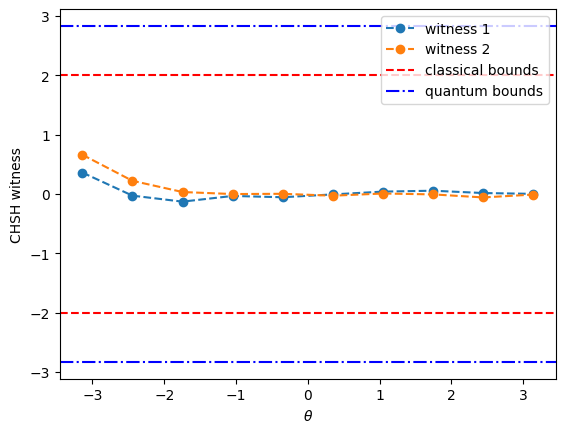

In [12]:
plt.plot(THETA_VALUES, chsh_witness1_theta, "o--", label="witness 1")
plt.plot(THETA_VALUES, chsh_witness2_theta, "o--", label="witness 2")
plt.xlabel(r"$\theta$")
plt.ylabel("CHSH witness")
plt.axhline(2, color="red", linestyle="--", label="classical bounds")
plt.axhline(-2, color="red", linestyle="--")
plt.axhline(2*np.sqrt(2), color="blue", linestyle="-.", label="quantum bounds")
plt.axhline(-2*np.sqrt(2), color="blue", linestyle="-.")
plt.legend()
# plt.savefig("chsh_result_no_calibration.png")

In [13]:
#np.save("chsh_theta_results", chsh_result_theta)
#np.save("calibration_results_theta", calibration_result_theta)
#np.save("theta_range", THETA_VALUES)